In [1]:
# default_exp subcoco_utils

# Common Utilities to Process Subcoco Dataset for both Pytorch Lightning and FastAI

In [2]:
#export 
import albumentations as A
import fastai
import icevision
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import pickle
import PIL
import pytorch_lightning as pl
import re
import requests
import sys
import tarfile
import torch
import torchvision

from collections import defaultdict
from functools import reduce
from icevision.core import BBox
from icevision.parsers import Parser
from icevision.parsers.mixins import LabelsMixin, BBoxesMixin, FilepathMixin, SizeMixin
from IPython.utils import io
from pathlib import Path
from PIL import Image, ImageStat
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.core.step_result import TrainResult
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
from typing import Hashable, List, Tuple, Union

In [3]:
#hide
from nbdev.showdoc import *

print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, albumentation {A.__version__}, pytorch_lightning {pl.__version__}, fastai {fastai.__version__}, icevision {icevision.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.6.0, torchvision 0.7.0, albumentation 0.4.6, pytorch_lightning 1.0.3, fastai 2.0.16, icevision 0.2.1.post1


## Reusable Function to fetch data from URL w/ Chunk Size and Progrgess

In [4]:
#export
def fetch_data(url:str, datadir: Path, tgt_fname:str, chunk_size:int=8*1024, quiet=False):
    dest = datadir/tgt_fname
    if not quiet: print(f"Downloading from {url} to {dest}...")
    with requests.get(url, stream=True, timeout=10) as response:
        content_len = int(response.headers['content-length'])
        with open(dest, 'wb') as f:
            with tqdm(total=content_len) as pbar:
                nbytes = 0
                num_chunks = 0
                for chunk in response.iter_content(chunk_size=chunk_size):
                    chunk_len = len(chunk)
                    nbytes += chunk_len
                    num_chunks += 1
                    f.write(chunk)
                    pbar.update(chunk_len)

    with tarfile.open(dest, 'r') as tar:
        extracted = []
        for item in tar:
            tar.extract(item, datadir)
            extracted.append(item.name)

    if not quiet: print(f"Downloaded {nbytes} from {url} to {dest}, extracted in {datadir}: {extracted[:3]},...,{extracted[-3:]}")

In [5]:
datadir = Path("/tmp")
froot = "coco_tiny"
fname = f"{froot}.tgz"
url = f"http://files.fast.ai/data/examples/{fname}"
json_fname = datadir/froot/'train.json'
img_dir = datadir/froot/'train'

fetch_data(url, datadir, fname, chunk_size=1024)
assert os.path.isdir(datadir/froot), f"Failed to download {datadir/froot}."
assert os.path.isdir(img_dir), f"Failed to find {img_dir}, may be extraction failed?"
assert len(os.listdir(img_dir)) > 0, f"Content of image directory {img_dir} is empty!"

100%|██████████| 801038/801038 [00:00<00:00, 26422221.86it/s]

Downloaded 801038 from http://files.fast.ai/data/examples/coco_tiny.tgz to /tmp/coco_tiny.tgz, extracted in /tmp: ['coco_tiny', 'coco_tiny/train', 'coco_tiny/train/000000283257.jpg'],...,['coco_tiny/train/000000291016.jpg', 'coco_tiny/train/000000193881.jpg', 'coco_tiny/train.json']


## Utilities to Load COCO Data and Compile Helpful Stats

In [6]:
#export
class CocoDatasetStats():
    # num_cats
    # num_imgs
    # num_bboxs
    # cat2name
    # class_map
    # lbl2cat
    # cat2lbl
    # img2fname
    # imgs
    # img2l2bs
    # img2lbs
    # l2ibs
    # avg_ncats_per_img
    # avg_nboxs_per_img
    # avg_nboxs_per_cat
    # img2sz
    # chn_means
    # chn_stds
    # avg_width
    # avg_height
    def __init__(self, ann:dict, img_dir:Path):
        
        self.img_dir = img_dir
        self.num_cats = len(ann['categories'])
        self.num_imgs = len(ann['images'])
        self.num_bboxs = len(ann['annotations'])
        
        # build cat id to name, assign FRCNN 
        self.cat2name = { c['id']: c['name'] for c in ann['categories'] }
        
        # need to translate coco subset category id to indexable label id
        # expected labels w 0 = background
        self.lbl2cat = { i: cid for i, cid in enumerate(self.cat2name.keys(),1) }
        self.cat2lbl = { cid: l for l, cid in self.lbl2cat.items() }
        self.lbl2name = { l:self.cat2name[cid] for l, cid in self.lbl2cat.items() }
        self.lbl2cat[0] = 0 # background
        self.cat2lbl[0] = 0 # background
        
        # img_id to file map
        self.img2fname = { img['id']:img['file_name'] for img in ann['images'] }
        self.imgs = [ { 'id':img_id, 'file_name':img_fname } for (img_id, img_fname) in self.img2fname.items() ]

        # compute Images per channel means and std deviation using PIL.ImageStat.Stat()
        
        self.img2sz = {}
        n = 0
        mean = np.zeros((3,))
        stddev = np.zeros((3,))
        avgw = 0
        avgh = 0
        for img in tqdm(self.imgs):
            img_id = img['id']
            fname = img_dir/img['file_name']
            n = n + 1
            img = Image.open(fname)
            istat = ImageStat.Stat(img)
            width, height = img.size
            avgw = (width + (n-1)*avgw)/n
            avgh = (height + (n-1)*avgh)/n
            mean = (istat.mean + (n-1)*mean)/n
            stddev = (istat.stddev + (n-1)*stddev)/n
            self.img2sz[img_id] = (width, height)
        
        self.chn_means = mean
        self.chn_stds = stddev
        self.avg_width = avgw
        self.avg_height = avgh
        
        # build up some maps for later analysis        
        self.img2l2bs = {}
        self.img2lbs = defaultdict(empty_list)
        self.l2ibs = defaultdict(empty_list)
        anno_id = 0
        for a in ann['annotations']:
            img_id = a['image_id']
            cat_id = a['category_id']
            lbl_id = self.cat2lbl[cat_id]
            l2bs_for_img = self.img2l2bs.get(img_id, { l:[] for l in range(1+len(self.cat2name))})
            (x, y, w, h) = a['bbox']
            b = (x, y, w, h) 
            ib = (img_id, *b)
            lb = (lbl_id, *b)
            l2bs_for_img[lbl_id].append(b)
            self.l2ibs[lbl_id].append(ib)
            self.img2lbs[img_id].append(lb)
            self.img2l2bs[img_id] = l2bs_for_img
            
        acc_ncats_per_img = 0.0
        acc_nboxs_per_img = 0.0
        for img_id, l2bs in self.img2l2bs.items():
            acc_ncats_per_img += len(l2bs)
            for lbl_id, bs in l2bs.items():
                acc_nboxs_per_img += len(bs)

        self.avg_ncats_per_img = acc_ncats_per_img/self.num_imgs
        self.avg_nboxs_per_img = acc_nboxs_per_img/self.num_imgs

        acc_nboxs_per_cat = 0.0
        for lbl_id, ibs in self.l2ibs.items():
            acc_nboxs_per_cat += len(ibs)

        self.avg_nboxs_per_cat = acc_nboxs_per_cat/self.num_cats

def empty_list()->list: return [] # cannot use lambda as pickling will fail when saving models

## Useful Function to Check for Pre-digested Stats to Avoid Rework

In [7]:
#export
def load_stats(ann:dict, img_dir:Path, force_reload:bool=False)->CocoDatasetStats:
    stats_fpath = img_dir/'stats.pkl'
    stats = None
    if os.path.isfile(stats_fpath) and not force_reload:
        try:
            stats = pickle.load( open(stats_fpath, "rb" ) )
        except Exception as e:
            print(f"Failed to read precomputed stats: {e}")

    if stats == None:
        stats = CocoDatasetStats(ann, img_dir)
        pickle.dump(stats, open(stats_fpath, "wb" ) )
        
    return stats

In [8]:
with open(json_fname, 'r') as json_f:
    train_json = json.load(json_f)
    
stats = load_stats(train_json, img_dir=img_dir, force_reload=True) 
assert stats.num_cats > 0, f"Categories can't be {stats.num_cats}. Stats computation bug?"
assert stats.num_imgs > 0, f"Num Images can't be {stats.num_imgs}. Stats computation bug?"
assert stats.num_bboxs > 0, f"Num Boxes can't be {stats.num_bboxs}. Stats computation bug?"
assert len(stats.cat2name) > 0, f"cat2name can't be {stats.cat2name}. Stats computation bug?"
assert len(stats.lbl2cat) > 0, f"lbl2cat can't be {stats.lbl2cat}. Stats computation bug?"
assert len(stats.cat2lbl) > 0, f"cat2lbl can't be {stats.cat2lbl}. Stats computation bug?"
assert len(stats.lbl2name) > 0, f"lbl2name can't be {stats.lbl2name}. Stats computation bug?"
assert stats.avg_width > 0 and stats.avg_height > 0, f"Avg (w,h) can't be {(stats.avg_width, stats.avg_height)}. Stats computation bug?"
assert stats.avg_ncats_per_img > 0, f"Avg cats/img can't be {stats.avg_ncats_per_img:.1f}. Stats computation bug?"
assert stats.avg_nboxs_per_img > 0, f"Avg boxs/img can't be {stats.avg_nboxs_per_img:.1f}. Stats computation bug?"
assert stats.avg_nboxs_per_cat > 0, f"Avg boxs/cat can't be {stats.avg_nboxs_per_cat:.1f}. Stats computation bug?"
assert stats.chn_means.all() > 0, f"Image means by channel can't be {stats.chn_means}. Stats computation bug?"
assert stats.chn_stds.all() > 0, f"Image std.dev by channel can't be {stats.chn_stds}. Stats computation bug?"

100%|██████████| 200/200 [00:00<00:00, 973.89it/s]


In [9]:
#hide
stats.cat2name, stats.lbl2cat, stats.cat2lbl, stats.lbl2name

({62: 'chair', 63: 'couch', 72: 'tv', 75: 'remote', 84: 'book', 86: 'vase'},
 {1: 62, 2: 63, 3: 72, 4: 75, 5: 84, 6: 86, 0: 0},
 {62: 1, 63: 2, 72: 3, 75: 4, 84: 5, 86: 6, 0: 0},
 {1: 'chair', 2: 'couch', 3: 'tv', 4: 'remote', 5: 'book', 6: 'vase'})

## Custom Parser for Icevision

In [10]:
#export
def box_within_bounds(x, y, w, h, width, height, min_margin_ratio, min_width_height_ratio):
    min_width = min_width_height_ratio*width
    min_height = min_width_height_ratio*height
    if w < min_width or h < min_height:
        return False
    top_margin = min_margin_ratio*height
    bottom_margin = height - top_margin
    left_margin = min_margin_ratio*width
    right_margin = width - left_margin
    if x < left_margin or x > right_margin:
        return False
    if y < top_margin or y > bottom_margin:
        return False
    return True

class SubCocoParser(Parser, LabelsMixin, BBoxesMixin, FilepathMixin, SizeMixin):
    def __init__(self, stats:CocoDatasetStats, min_margin_ratio = 0, min_width_height_ratio = 0, quiet = True):
        self.stats = stats
        self.data = [] # list of tuple of form (img_id, wth, ht, bbox, label_id, img_path)
        skipped = 0
        for img_id, imgfname in stats.img2fname.items():
            imgf = stats.img_dir/imgfname
            width, height = stats.img2sz[img_id]
            bboxs = []
            lids = []
            for lid, x, y, w, h in stats.img2lbs[img_id]:
                if lid != None and box_within_bounds(x, y, w, h, width, height, min_margin_ratio, min_width_height_ratio): 
                    b = [int(x), int(y), int(w), int(h)]
                    l = int(lid)
                    bboxs.append(b)
                    lids.append(l)
                else:
                    if not quiet: print(f"warning: skipping lxywh of {lid, x, y, w, h}")
            
            if len(bboxs) > 0:
                self.data.append( (img_id, width, height, bboxs, lids, imgf, ) )
            else:
                skipped += 1
                
        print(f"Skipped {skipped} out of {stats.num_imgs} images")

    def __iter__(self):
        yield from iter(self.data)

    def __len__(self):
        return len(self.data)

    def imageid(self, o) -> Hashable:
        return o[0]

    def filepath(self, o) -> Union[str, Path]:
        return o[5]

    def height(self, o) -> int:
        return o[2]

    def width(self, o) -> int:
        return o[1]

    def labels(self, o) -> List[int]:
        return o[4]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xywh(x,y,w,h) for x,y,w,h in o[3]]
        
    def image_width_height(self, o) -> Tuple[int, int]:
        img_id = o[0]
        return self.stats.img2sz[img_id] 

In [11]:
parser = SubCocoParser(stats, min_margin_ratio = 0.05, min_width_height_ratio = 0.05)
train_records, valid_records = parser.parse(autofix=False)
print(f"Number of train records {len(train_records)}, validation records {len(valid_records)}")
assert len(train_records) > 0, "There should be some training data."
assert len(valid_records) > 0, "There should be some validation data."

Skipped 55 out of 200 images



Number of train records 116, validation records 29


## Utility to Check if Code is Running in Notebook

Copied from [Stack Overflow](https://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook)

In [12]:
#export
def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [13]:
#hide
if is_notebook():
    print("I am running inside a notebook!")

I am running inside a notebook!


## Lower Level Utilities

In [14]:
#export
def overlay_img_bbox(img:Image, l2bs: dict, l2name: dict):
    l2color = { l: colname for (l, colname) in zip(l2bs.keys(), mcolors.TABLEAU_COLORS.keys()) }
    fig = plt.figure(figsize=(16,10))
    fig = plt.imshow(img)
    for l, bs in l2bs.items():
        for b in bs:
            label_for_bbox(b, l2name[l])
            fig.axes.add_patch(bbox_to_rect(b, l2color[l]))
            
def bbox_to_rect(bbox:Tuple[int, int, int, int], color:str):
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2], height=bbox[3],
        fill=False, edgecolor=color, linewidth=2)

def label_for_bbox(bbox:Tuple[int, int, int, int], label:str):
    return plt.text(bbox[0], bbox[1], f"{label}", color='#ffffff', fontsize=12)

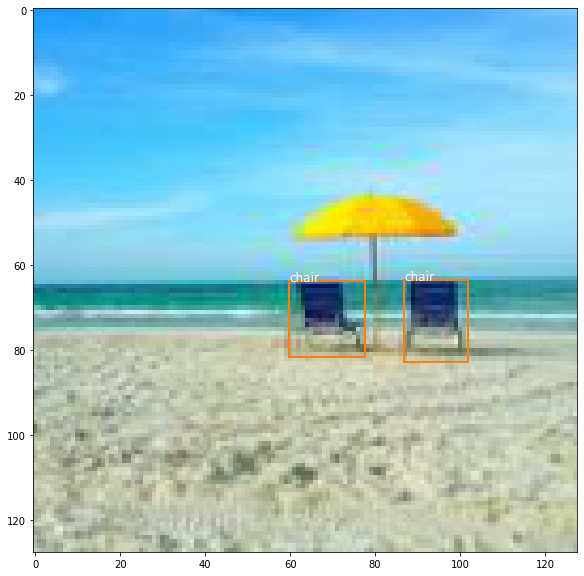

In [15]:
img_id = train_json['images'][128]['id']
l2bs = stats.img2l2bs[img_id]
img_fname = stats.img2fname[img_id]
img = Image.open(img_dir/img_fname)
overlay_img_bbox(img, l2bs, stats.lbl2name)

## Wrap Data Loading Logic using Pytorch-Lightning

In order to use Pytorch Lightning to load data, we need to define a DataModule to encapsulate all the data loading logic. At first I thought I can reuse CocoDetect() from torchvision but it uses cocoapi downstream and expects json annotation file to be of this [format](https://cocodataset.org/#format-data):
```
annotation{
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height],
    "iscrowd": 0 or 1,
}
```

Tiny and Sample Coco's train.json file only has a subset of the above fields:
```
“Annotations”: [
    {
      "image_id": 542959,
      "bbox": [
        32.52,
        86.34,
        8.53,
        9.41
      ],
      "category_id": 62
    },
    ...
]
``` 

Thus we will need to make a Dataset to handle it properly.

In [16]:
# export
class SubCocoDataset(torchvision.datasets.VisionDataset):
    """
    Simulate what torchvision.CocoDetect() returns for target given fastai's coco subsets
    Args:
        root (string): Root directory where images are downloaded to.
        stats (CocoDatasetStats): 
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version.
    """

    def __init__(self, root, stats, transform=None, target_transform=None, transforms=None):
        super(SubCocoDataset, self).__init__(root, transforms, transform, target_transform)
        self.stats = stats
        self.img_ids = list(stats.img2fname.keys())

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        img_id = self.img_ids[index] if index < len(self.img_ids) else 0
        img_fname = self.stats.img2fname.get(img_id, None)
        if img_id == None or img_fname ==None:
            return (None, None)
        
        img = Image.open(os.path.join(self.root, img_fname)).convert('RGB')
        target = { "boxes": [], "labels": [], "image_id": None, "area": [], "iscrowd": 0, "ids": [] }
        count = 0
        lbs = self.stats.img2lbs.get(img_id,[])
        for l, x, y, w, h in lbs:
            count += 1
            target["boxes"].append([x, y, x+w, y+h]) # FRCNN wants x1,y1,x2,y2 format!
            target["labels"].append(l)
            target["image_id"] = img_id
            target["area"].append(w*h)
            anno_id = img_id*1000 + count
            target["ids"].append(anno_id)

        for k, v in target.items():
            target[k] = torch.tensor(v)

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        else:
            if self.transform is not None: img = self.transform(img)
            if self.target_transform is not None: target = self.target_transform(target)

        return img, target

    def __len__(self):
        return self.stats.num_imgs

It is standard to do some transformation when preparing image data.  I am providing a simple target transform to complement Torchvision's Resize.  To do any more non-basic transform, one should really use Albumentation for it.

In [17]:
#export
class TargetResize():
    
    def __init__(self, stats:CocoDatasetStats , to_size:Tuple[int, int]):
        self.stats = stats
        self.to_width, self.to_height = to_size

    def __call__(self, tgt:dict):
        img_id = tgt['image_id']
        img_w, img_h = self.stats.img2sz[img_id.item()]
        tfm_boxes = []
        x_ratio = self.to_width/img_w
        y_ratio = self.to_height/img_h
        tgt['orig_boxes'] = tgt['boxes'] # save to preserve info
        for (bx1, by1, bx2, by2) in tgt['boxes']:
            tx1 = bx1 * x_ratio
            ty1 = by1 * y_ratio
            tx2 = bx2 * x_ratio
            ty2 = by2 * y_ratio
            tfm_boxes.append((tx1,ty1,tx2,ty2))
        tgt['boxes'] = torch.tensor(tfm_boxes)
        return tgt


In [18]:
tfm = transforms.Compose([ transforms.Resize((384,384)), transforms.ToTensor() ])
fcoll = lambda batch: tuple(zip(*batch))

tgt_tfm = transforms.Compose([ TargetResize(stats, (384,384)) ])

dataset = SubCocoDataset(img_dir, stats, transform=tfm, target_transform=tgt_tfm) # Have to transform target by (384,384)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=1, collate_fn=fcoll)
# For Training
images,targets = next(iter(data_loader))
(images), (targets)

((tensor([[[0.9373, 0.9373, 0.8706,  ..., 0.8275, 0.8667, 0.8667],
           [0.9373, 0.9373, 0.8706,  ..., 0.8275, 0.8667, 0.8667],
           [0.8902, 0.8902, 0.8196,  ..., 0.7843, 0.8353, 0.8353],
           ...,
           [0.7608, 0.7608, 0.6745,  ..., 0.8627, 0.8745, 0.8745],
           [0.8392, 0.8392, 0.7765,  ..., 0.8941, 0.8980, 0.8980],
           [0.8392, 0.8392, 0.7765,  ..., 0.8941, 0.8980, 0.8980]],
  
          [[0.8706, 0.8706, 0.7961,  ..., 0.8118, 0.8510, 0.8510],
           [0.8706, 0.8706, 0.7961,  ..., 0.8118, 0.8510, 0.8510],
           [0.8235, 0.8235, 0.7451,  ..., 0.7686, 0.8196, 0.8196],
           ...,
           [0.6902, 0.6902, 0.6000,  ..., 0.8471, 0.8588, 0.8588],
           [0.7647, 0.7647, 0.6980,  ..., 0.8784, 0.8824, 0.8824],
           [0.7647, 0.7647, 0.6980,  ..., 0.8784, 0.8824, 0.8824]],
  
          [[0.8000, 0.8000, 0.7216,  ..., 0.7647, 0.8039, 0.8039],
           [0.8000, 0.8000, 0.7216,  ..., 0.7647, 0.8039, 0.8039],
           [0.7529, 0.

Let's visually insepct to makesure transformation is correct.

(defaultdict(<function __main__.empty_list() -> list>,
             {1: [(97, 259, 25, 28),
               (331, 332, 43, 45),
               (289, 150, 56, 40),
               (2, 335, 35, 39)],
              6: [(294, 331, 5, 12), (273, 154, 11, 17)]}),
 defaultdict(<function __main__.empty_list() -> list>,
             {1: [(32, 86, 8, 9),
               (110, 110, 14, 15),
               (96, 50, 18, 13),
               (0, 111, 11, 13)],
              6: [(98, 110, 1, 4), (91, 51, 3, 5)]}))

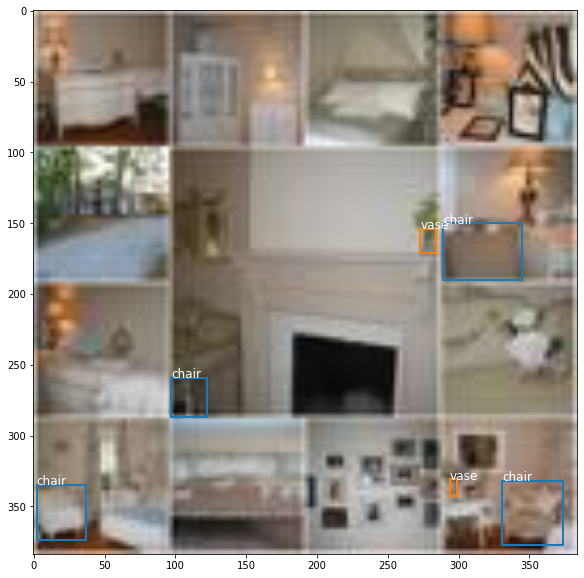

In [19]:
x = images[0]
y = targets[0]
tgt_l2bs = defaultdict(empty_list)
for l, b in zip(list(y['labels']), y['boxes']):
    tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 
           
tgt_l2obs = defaultdict(empty_list)
for l, b in zip(list(y['labels']), y['orig_boxes']):
    tgt_l2obs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) )
           
pimg = torchvision.transforms.ToPILImage()(x)
overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)
tgt_l2bs, tgt_l2obs

Compared to original...

{0: [],
 1: [(32.52, 86.34, 8.53, 9.41),
  (110.48, 110.82, 14.55, 15.22),
  (96.63, 50.18, 18.67, 13.46),
  (0.69, 111.73, 11.8, 13.06)],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [(98.12, 110.52, 1.95, 4.07), (91.28, 51.62, 3.95, 5.72)]}

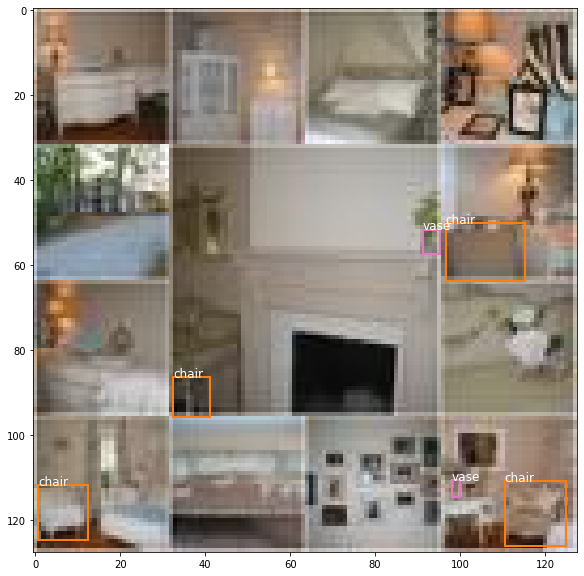

In [20]:
img_id = y['image_id'].item()
l2bs = stats.img2l2bs[img_id]
img_fname = stats.img2fname[img_id]
img = Image.open(img_dir/img_fname)
overlay_img_bbox(img, l2bs, stats.lbl2name)
l2bs

## Custom DataModule

In [21]:
#export
class SubCocoDataModule(LightningDataModule):

    def __init__(self, root, stats, resize=(384,384), bs=32, workers=4, split_ratio=0.8):
        super().__init__()
        self.dir = root
        self.bs = bs
        self.workers = workers 
        self.stats = stats
        self.split_ratio = split_ratio
        
        # transforms for images
        transform=transforms.Compose([
            transforms.Resize(resize), 
            transforms.ToTensor(), 
            transforms.Normalize(stats.chn_means/255, stats.chn_stds/255) # need to divide by 255
        ])

        tgt_tfm = transforms.Compose([ TargetResize(stats, resize) ])
        
        # prepare transforms for coco object detection
        dataset = SubCocoDataset(self.dir, self.stats, transform=transform, target_transform=tgt_tfm)
        num_items = len(dataset)
        num_train = int(self.split_ratio*num_items)
        self.train, self.val = random_split(dataset, (num_train, num_items-num_train), generator=torch.Generator().manual_seed(42))
        # print(self.train, self.val)

    def collate_fn(self, batch):
        return tuple(zip(*batch))
    
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.bs, num_workers=self.workers, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.bs, num_workers=self.workers, collate_fn=self.collate_fn)

In [22]:
tiny_coco_dm = SubCocoDataModule(img_dir, stats, bs=2)
tdl=tiny_coco_dm.train_dataloader()
images, targets = next(iter(tdl))
len(images), len(targets)

(2, 2)

## Wrapper Around COCOAPI Metrics

In my initial attempt to port the example code Faster RCNN code to Pytorch-Lightning, I realized soon computing metrics is going to tricky. In fact, I don't actually know even what metrics to use!  Luckily someone pointed me to this well written [article by Raphael Padilla](https://github.com/rafaelpadilla/Object-Detection-Metrics) which explains the metrics used in object detection today. 

The following is my attempt to repurpose [CocoAPI](https://github.com/cocodataset/cocoapi/) which has builtin metric evaluation instead of rolling my own evaluation metrics.  But it was painful as Coco API was not written for easy extension in mind.  For example, it tightly couples JSON file loading (and its format) into metrics computation, so I had to look under the cover for its implementation to then use it in a way that is probably not appropriate.  Also it tighly couple the computation of metrics with the batching of data.

I ended up just writing a wrapper that uses a separate Coco Object for each ground truth and prediction, as if the whole epoch has only 1 sample. 

In [23]:
# export
class SubCocoWrapper():
    def __init__(self, categories, p, t):
        # turn tgt: { "boxes": [...], "labels": [...], "image_id": "xxx", "area": [...], "iscrowd": 0 }
        # into COCO with dataset dict of this form:
        # { images: [], categories: [], annotations: [{"image_id": int, "category_id": int, "bbox": (x,y,width,height)}, ...] }
        # see https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
        with io.capture_output() as captured:
            self.target = COCO()
            img_id = int(t["image_id"]) # could be tensor, cast to int
            images = [ {'id': img_id, 'file_name': f"{img_id:012d}.jpg"} ]
            self.target.dataset["images"] = images
            self.target.dataset["categories"] = categories
            self.target.dataset["annotations"] = []
            for bi, b in enumerate(t["boxes"]):
                x, y, w, h = b
                cat_id = t["labels"][bi]
                anno_id = t["ids"][bi]
                self.target.dataset["annotations"].append({'id': anno_id, 'image_id': img_id, 'category_id': cat_id, 'bbox': b})
            self.target.createIndex()

            # [ {'boxes': tensor([[100.5,  39.7, 109.1,  52.7], [110.9,  41.1, 120.4,  54.4], [ 36.6,  56.1,  46.9,  74.0]], device='cuda:0'), 
            #    'labels': tensor([1, 1, 1], device='cuda:0'), 
            #    'scores': tensor([0.7800, 0.7725, 0.7648], device='cuda:0')}, ...]
            # numpy array [Nx7] of {imageID,x1,y1,w,h,score,class}
            pna = np.zeros((len(p["boxes"]), 7))
            for bi, b in enumerate(p["boxes"]):
                pna[bi]=(img_id, *b, p["scores"][bi], p["labels"][bi])

            anns = self.target.loadNumpyAnnotations(pna)
            self.prediction = COCO()
            self.prediction.dataset["images"] = images
            self.prediction.dataset["categories"] = categories
            self.prediction.dataset["annotations"] = anns

    def targetCoco(self): 
        return self.target
    
    def predictionCoco(self): 
        return self.prediction

Using the above wrapper, I can then compute the metric for the 1 sample epoch to get the metrics I want for the image
* Mean Average Precision (MAP)
* Mean Average Recall (MAR) 
* over a range of Intersection over Union (IOU) values from 50% to 95%
* then combined it using [F1](https://en.wikipedia.org/wiki/F1_score)

I should be able to use the above to do something like this:
```
    subcoco = SubCocoWrapper(categories, predictions, targets)
    cocoeval = COCOeval(subcoco.targetCoco(), subcoco.predictionCoco(), "bbox")
    cocoeval.evaluate()
    cocoeval.accumulate()
    cocoeval.summarize()
    precision = cocoeval.stats[0] # Average Precision (AP) @[ IoU=0.50:0.95 | area=all | maxDets=100 ]
    recall = cocoeval.stats[8] # Average Recall (AR) @[ IoU=0.50:0.95 | area=all | maxDets=100 ]
    f1 = 2/(1/precision + 1/recall) # see https://en.wikipedia.org/wiki/F1_score
```
But after messing with this for a few days, it doesn't seem to be working. My precision and recall is always coming back -1, so my f1 is also always -1. I suspect my understanding or usage of CocoEval is wrong... 

## Alternative Validation Metrics (not affecting training)

Decided to roll my own metrics by the following logic.

* pick all prediction boxes (pbox) with scores above cutoff score (scut) 
* compute all Intersection over Union (IoU) of all pbox and target boxes (tbox), take only pbox and tbox combo of IoU above IoU threshold (ithr)
* for each category C in target
    * true positives (TF): num box (pcat == tcat) above ithr
    * false positives (FP): num box (pcat != tcat) above ithr
    * precision = TP/(TP+FP), recall = TP/(TP+FN) or TP/(num target boxes of C)
    * F1 = 1/(1/prec + 1/recall)
* accuracy = weighted mean by num target boxes of all C's F1 score

In [24]:
# export
def iou_calc(x1,y1,w1,h1, x2,y2,w2,h2):
    r1 = x1+w1 # right of box1
    b1 = y1+h1 # bottom of box1
    r2 = x2+w2 # right of box2
    b2 = y2+h2 # bottom of box2
    a1 = w1*h1
    a2 = w2*h2
    ia = 0. # intercept
    if x1 <= x2 <= r1:
        if y1 <= y2 <= b1:
            ia = (r1-x2)*(b1-y2)
        elif y1 <= b2 <= b1:
            ia = (r1-x2)*(b1-b2)
    elif x1 <= r2 <= r1:
        if y1 <= y2 <= b1:
            ia = (r1-r2)*(b1-y2)
        elif y1 <= b2 <= b1:
            ia = (r1-r2)*(b1-b2)
    iou = ia/(a1+a2-ia)
    # print(x1,y1,w1,h1, x2,y2,w2,h2,iou)
    return iou

def accuracy_1img(pred, tgt, scut=0.5, ithr=0.5):
    scut = 0.6
    ithr = 0.1
    pscores = pred['scores']
    pidxs = (pscores > scut).nonzero(as_tuple=True)
    pboxs = pred['boxes'][pidxs]
    tboxs = tgt['boxes']
    tls = tgt['labels']
    pls = pred['labels']
    tlset = {l for l in tls}
    
    tl2num = defaultdict(lambda:0)
    for tl in tls: tl2num[tl]+=1

    tlpls = []
    for tl,tb in zip(tls,tboxs):
        for pl,pb in zip(pls,pboxs):
            iou = iou_calc(*tb, *pb)
            # print(iou)
            if iou > ithr: tlpls.append((tl,pl))

    tl2tpfp = defaultdict(lambda: (0,0))
    for tl in tlset:
        for tl, pl in tlpls:
            tp, fp = tl2tpfp[tl]
            if tl == pl:
                tp+=1
            else:
                fp+=1
            tl2tpfp[tl] = (tp, fp)

    tl2f1 = {}
    for tl in tlset:
        tp, fp = tl2tpfp[tl]
        tlnum = tl2num[tl]
        precision = 0 if tp == 0 else tp/(tp+fp)
        recall = 0 if tp == 0 else tp/tlnum
        f1 = 0 if precision*recall == 0 else 2/(1/precision + 1/recall)
        tl2f1[tl] = f1
    
    acc = 0.
    tnum = len(tgt['boxes'])
    for tl, f1 in tl2f1.items():
        tlnum = tl2num[tl]
        f1 = tl2f1[tl]
        acc += f1*(tlnum/tnum)
    
    return acc

There are Many object detection models to choose from.

To break my anaylysis paralysis researching and deciding between the various models and architectures, I decided to push ahead with what is provided by TorchVision out of the box i.e. Faster R-CNN with pretrained ResNet backbone. 

Luckily there is a turorial to follow
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

First, let's just use the raw model directly and verify the outputs by using raw torchvision model to perform some prediciton to test custom metric function.

In [25]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, stats.num_cats+1) # to account for 0:backgrnd
images, targets = next(iter(tdl))
images = list(img for img in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# how to get both in 1 step?
model.train()
losses = model(images,targets) 
model.eval()
predict = model(images)
acc = accuracy_1img(predict[0], targets[0], .1, .1)
acc

0.0

## Packaging Model and Metric Into A Lightning Module

In [26]:
# export
class FRCNN(LightningModule):
    def __init__(self, lbl2name:dict={}, lr:float=1e-2):
        LightningModule.__init__(self)
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        # lock the pretrained model body
        for param in self.model.parameters():
            param.requires_grad = False
            
        # get number of input features of classifier
        self.in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        
        #refit another head
        self.categories = [ {'id': l, 'name': n } for l, n in lbl2name.items() ]
        self.num_classes = len(self.categories)  
        # replace the pre-trained head with a new one, which is trainable
        self.model.roi_heads.box_predictor = FastRCNNPredictor(self.in_features, self.num_classes+1)
        
        self.lr = lr
        
    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True
        self.lr = self.lr / 10
        configure_optimizers()
            
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        losses = self.model(x, y)
        loss = sum(losses.values())
        result = {'loss':loss, 'train_loss':loss}
        return result

    def metrics(self, preds, targets):
        accu = torch.zeros((len(preds), 1))
        for i, (p,t) in enumerate(zip(preds, targets)):
            accu[i] = accuracy_1img(p, t, .3, .3)
        return torch.tensor(accu)
        
    def validation_step(self, val_batch, batch_idx):
        # validation runs the model in eval mode, so Y is prediction, not losses
        xs, ys = val_batch
        preds = self.model(xs, ys)
        accu = self.metrics(preds, ys)
        return {'val_acc': accu} # should add 'val_acc' accuracy e.g. MAP, MAR etc

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def validation_epoch_end(self, outputs):
        # called at the end of the validation epoch, but gradient accumulation may result in last row being different size
        val_accs = np.concatenate([ (o['val_acc']).numpy() for o in outputs ])
        avg_acc = val_accs.mean()
        tensorboard_logs = {'val_acc': avg_acc}
        return {'val_acc': avg_acc, 'logs': tensorboard_logs}
        
    def forward(self, x):
        self.model.eval()
        pred = self.model(x)
        return pred

In [27]:
frcnn_model = FRCNN(stats.lbl2name)
chkpt_cb = ModelCheckpoint(
    filepath=f"/tmp/FRCNN-{froot}.ckpt",
    save_last=True,
    monitor='val_acc',
    mode='max'
)
# train
trainer = Trainer(gpus=1, max_epochs=1, checkpoint_callback=chkpt_cb, accumulate_grad_batches=2)
trainer.fit(frcnn_model, tiny_coco_dm)
frcnn_model.unfreeze() # allow finetuning of the backbone
trainer.fit(frcnn_model, tiny_coco_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  


<ipython-input-26-d2cd555a1c6d>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(accu)
/home/brian_guan_gmail_com/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


Saving latest checkpoint...

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  


1

We've tested using Pytorch Lightning to save and load pretrained model but found [bug](https://github.com/PyTorchLightning/pytorch-lightning/issues/2550).

In [28]:
#hide

# # Saving using Pytorch Lightning is Not Working
# # see https://github.com/PyTorchLightning/pytorch-lightning/issues/2550
# model_save_path = f"/tmp/FRCNN-{froot}-final.saved"
# trainer.save_checkpoint(model_save_path)
# pretrained_model = FRCNN(stats.lbl2name)
# pretrained_model = pretrained_model.load_from_checkpoint(model_save_path)
# pretrained_model.eval()

## Utility to Drive Inference in PytorchLightning

In [29]:
#export
def digest_pred(l2name, pred, cutoff=0.5):
    scores = pred['scores']
    pass_idxs = (scores > cutoff).nonzero(as_tuple=False)
    lbls = pred['labels'][pass_idxs]
    bboxs = pred['boxes'][pass_idxs]
    l2bs = defaultdict(lambda: [])
    for l, b in zip(lbls, bboxs):
        x,y,w,h = b[0]
        n = l2name[l.item()]
        bs = l2bs[l.item()]
        bs.append((x.item(),y.item(),w.item(),h.item()))
    return l2bs

Prediction is going to be garbage since we only train for 1 epoch but just want to make sure whole pipeline doesn't bomb.

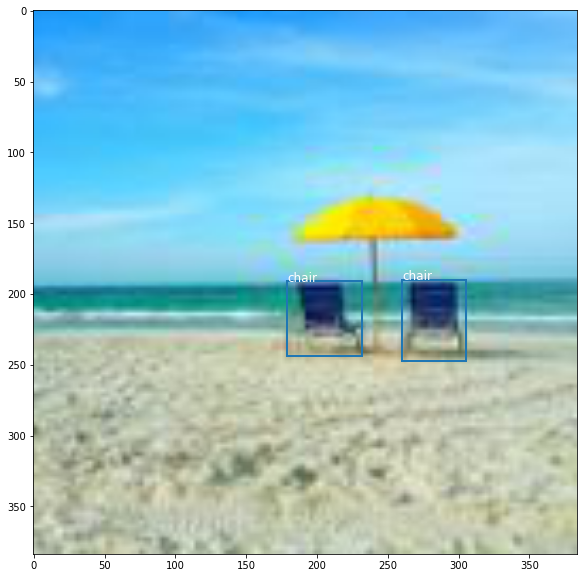

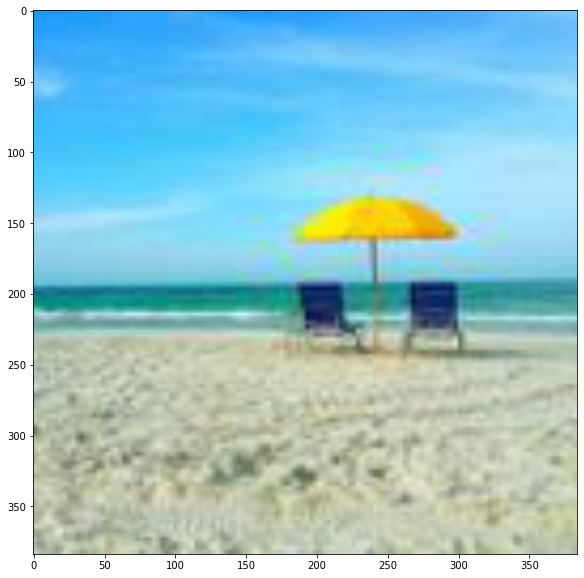

In [30]:
x, y = dataset[128]
pimg = torchvision.transforms.ToPILImage()(x)
tgt_l2bs = defaultdict(empty_list)
for l, b in zip(list(y['labels']), y['boxes']):
    tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 
           
overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

frcnn_model.eval()
pred = frcnn_model([x.cuda()])
pred_l2bs = digest_pred(stats.lbl2name, pred[0], cutoff=0.1)
overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)

Verify saving model and loading works using underlying Pytorch.

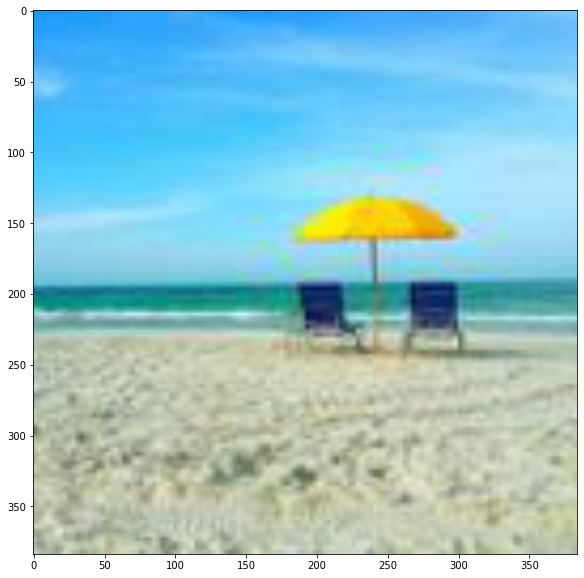

In [32]:
model_save_path = f"/tmp/FRCNN-{froot}-final.saved"
torch.save(frcnn_model.model.state_dict(), model_save_path)
pretrained_model = FRCNN(stats.lbl2name)
pretrained_model.model.load_state_dict(torch.load(model_save_path))
pretrained_model.freeze()
pretrained_model.eval()
pred = pretrained_model([x])
pred_l2bs = digest_pred(stats.lbl2name, pred[0], cutoff=0.1)
overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)

## Export to Regular Python Script as 'subcoco_utils.py'

In [33]:
#hide
from nbdev.export import *
notebook2script(fname='10_subcoco_utils.ipynb')

Converted 10_subcoco_utils.ipynb.
